# Inverse Theory Assignment 2
*By Ryan Cox*

I'll start with some general code that'll be used all over.

In [1]:
using SparseArrays
using Distributions
using Krylov
using LinearAlgebra
using Plots
using LaTeXStrings
using BenchmarkTools

In [2]:
"""
Generate some synthetic data by applying gaussian noise to model

Parameters
    G::Matrix - Model kernel
    m::Vector - True parameters
    mean::Number - Mean of gaussian noise
    std::Number - Standard deviation of gaussian noise
"""
function FakeNormalData(G::Union{Matrix, SparseMatrixCSC}, m::Vector, mean::Number, std::Number)::Vector
    N = size(G)[1] # get num. of data elements
    gaussian = Normal(mean, std)
    n = rand(gaussian, N) # N gaussian random numbers
    d = G * m + n
end

"""
Find cov(m) given kernel G and standard deviation of data. Not efficent for large G.
"""
function Covariance(G::Union{Matrix,SparseMatrixCSC}, std::Number)::Matrix
    G = Matrix(G)
    std^2 * inv(transpose(G) * G)
end;

# Q1 | Problem 3.1

Start with Eq 3.6
$$\frac{\partial E}{\partial m_1} = 2Nm_1 + 2m_2\sum_{i=1}^Nz_i - 2\sum_{i=1}^Nd_i = 0$$
$$\frac{\partial E}{\partial m_2} = 2m_1\sum_{i=1}^Nz_i + 2m_2\sum_{i=1}^Nz_i^2 - 2\sum_{i=1}^Nz_id_i = 0$$
Divide by two
$$Nm_1 + m_2\sum_{i=1}^Nz_i - \sum_{i=1}^Nd_i = 0$$
$$m_1\sum_{i=1}^Nz_i + m_2\sum_{i=1}^Nz_i^2 - \sum_{i=1}^Nz_id_i = 0$$
Shift last term
$$Nm_1 + m_2\sum_{i=1}^Nz_i = \sum_{i=1}^Nd_i$$
$$m_1\sum_{i=1}^Nz_i + m_2\sum_{i=1}^Nz_i^2 = \sum_{i=1}^Nz_id_i$$
Turn into a matrix
$$\begin{bmatrix} \sum_{i=1}^Nd_i \\ \sum_{i=1} Nz_id_i \end{bmatrix} = \begin{bmatrix} Nm_1 & m_2\sum_{i=1}^Nz_i \\ m_1\sum_{i=1}^Nz_i & m_2\sum_{i=1}^Nz_i^2 \\ \end{bmatrix}$$
Split out $\mathbf{m}$
$$\begin{bmatrix} \sum_{i=1}^Nd_i \\ \sum_{i=1} Nz_id_i \end{bmatrix} = \begin{bmatrix} N & \sum_{i=1}^Nz_i \\ \sum_{i=1}^Nz_i & \sum_{i=1}^Nz_i^2 \\ \end{bmatrix} \begin{bmatrix} m_1 \\ m_2 \end{bmatrix}$$
Solve for $\mathbf{m}$
$$\begin{bmatrix} m_1 \\ m_2 \end{bmatrix} = \begin{bmatrix} N & \sum_{i=1}^Nz_i \\ \sum_{i=1}^Nz_i & \sum_{i=1}^Nz_i^2 \\ \end{bmatrix}^{-1} \begin{bmatrix} \sum_{i=1}^Nd_i \\ \sum_{i=1} Nz_id_i \end{bmatrix}$$
Which is Eq 3.18, showing it is a valid solution

# Q2 | Problem 3.2

In [3]:
# Function taken from Assignment 1
"""Make NxN square matrix and fill it with triplets of a coefficent a.
In a row with index r, the cells [r, r], [r, r-1], [r, r-2] are filled.
Argument a multipes the entire matrix by scalar a.
For example TripletsMatrix(5, 1) produces the sparse matrix
   [1 0 0 0 0;
    1 1 0 0 0;
    1 1 1 0 0;
    0 1 1 1 0;
    0 0 1 1 1]"""
function TripletsMatrix(N::Int, a=1::Number)::SparseMatrixCSC  # a is probably unneccessary (vs hardcoding a=1) except in some odd cases, but including it is trivial.
    #= We are creating a matrix with COO, a coordinate list.
    For some k, row[k] gives row index, col[k] gives col index and val[k] gives the value for that coordinate pair.
    We create the matrices in advance then increment over vector coordiantes with k because it is reportedly faster than appending to matrices. =#
    
    if N < 2 error("N should be at least 2.") end
    
    col = Vector{Int64}(undef, 3*(N-1)) # 3*(N-1) should be the amount of nonzero values <- 3 from the first two rows and 3*(N-2) from the rest.
    row = Vector{Int64}(undef, 3*(N-1))
    val = Vector{Float64}(undef, 3*(N-1))
    k = 1 # This tracks our location in the COO vectors
    for i = 1:N # Row index.
        for j in i-2:i # Column index, for non-zero values. We don't write to any columns higher than i so this doesn't do anything weird in the last row.
            if j > 0 # To handle first two rows.
                col[k] = j
                row[k] = i
                val[k] = a
                k += 1
            end
        end
    end
    sparse(row, col, val) # Takes our vectors and turns them into a sparse matrix
end


function WithinTwoSTD(actual::Vector, est::Vector, std::Vector)::Int
    diff = abs.(actual .- est)
    twosigma = diff[diff .< (2*std)]
    length(twosigma)
end;

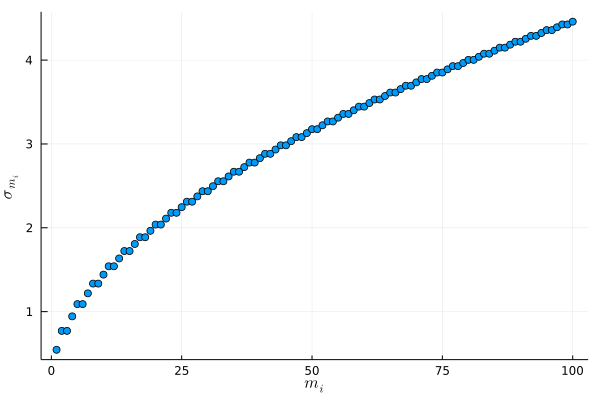

In [4]:
N = 100 # number of objects

# (A) Randomly assign true masses (0,1] to N objects
mTrue = 1 .- rand(Float64, N) # note subtraction from 1 to convert from [0,1)

# (B) create data kernal G
G = TripletsMatrix(N) 

# (C) Synthesise some data
d = FakeNormalData(G, mTrue, 0, 0.01)

# (D) Least squares solution for m.
# This lovely function, implemented by Krylov.jl, uses a conjugate gradient method to solve least squares quickly (~ 0.17 ms for this).
# See https://juliasmoothoptimizers.github.io/Krylov.jl/stable/solvers/ls/#Krylov.cgls
# I looked at the BiCG method suggested in Menke, but had some problems with the Julia equivilant (doesn't like a function argument).
# I also tried straight up solving the matrix eq:
#   m = inv(transpose(T) * G) * (transpose(G) * d)
# but that was (predicatably) slow.
(mEst, stats) = cgls(G, d)
# (E) Estimate variance of est. model params
# Slow but works for this small N
dDevEst = std(d)
mCov = Covariance(G, dDevEst)
mVar = diag(mCov) # Extract vector of variances for mEst from diagonal

# (F) Count number of model params within 2 std. of true value
mStd = mVar .^ 0.5
WithinTwoSTD(mTrue, mEst, mStd)
# (G) Plot model variance as function of index
plot(mStd, seriestype = :scatter, xlabel = L"m_i", ylabel = L"\sigma_{m_i}", legend=false) # std increases weith i

## Design Note

In [5]:
"""
An alternate function that achieves the same result as TripletsMatrix

The assignment question suggests "Try to see if you can construct G without using loops over columns and rows."
For the last assignment I wrote TripletsMatrix, which uses loops and COO. That isn't looping over columns and rows but it has some similarities.
TripletsMatrix does include a lot of looping, if not over rows and columns, so I decided to give it a go.
I discovered the function diagm() which constructs matrices from diagonals and created the short function below.
However, the benchmarks show that it is many times slower and uses much more memory.
I am hence only including it here to show the attempt.
"""
function TripletsMatrixDiag(N::Int, a=1::Number)
    d1 = fill(a, N)
    dn1 = fill(a, N-1)
    dn2 = fill(a, N-2)
    diagm(0 => d1, -1 => dn1, -2 => dn2)
end

display(@benchmark TripletsMatrix(1000))
display(@benchmark TripletsMatrixDiag(1000))

BechmarkTools.Trial: 10000 samples with 1 evaluations.
 Range (min … max):   41.500 μs …   8.323 ms  ┊ GC (min … max):  0.00% … 98.21%
 Time  (median):     124.500 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   137.408 μs ± 326.674 μs  ┊ GC (mean ± σ):  14.54% ±  6.29%

  ▇▅▂▁  ▁▁ ▂▄█▆▄▃▂▂▁▃▃▂▂▁                                       ▂
  ████████████████████████▇▆▇▆▆▆▅▄▅▅▅▅▆▃▅▅▅▄▄▅▄▄▅▄▄▅▄▃▅▃▄▂▂▃▄▂▃ █
  41.5 μs       Histogram: log(frequency) by time        482 μs <

 Memory estimate: 188.83 KiB, allocs estimate: 23.

BechmarkTools.Trial: 1306 samples with 1 evaluations.
 Range (min … max):  2.004 ms … 40.541 ms  ┊ GC (min … max):  0.00% … 13.86%
 Time  (median):     2.960 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.796 ms ±  2.347 ms  ┊ GC (mean ± σ):  21.85% ± 23.72%

     ▄▃█▅▅▄                                                   
  ▃▇███████▇▄▅▄▅▃▄▃▃▃▂▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▂▂▂▃▃▄▃▃▃▃▃▃▃▃▃▂▃▂▂ ▃
  2 ms           Histogram: frequency by time        9.83 ms <

 Memory estimate: 7.74 MiB, allocs estimate: 6013.

# Q3 | Problem 3.4

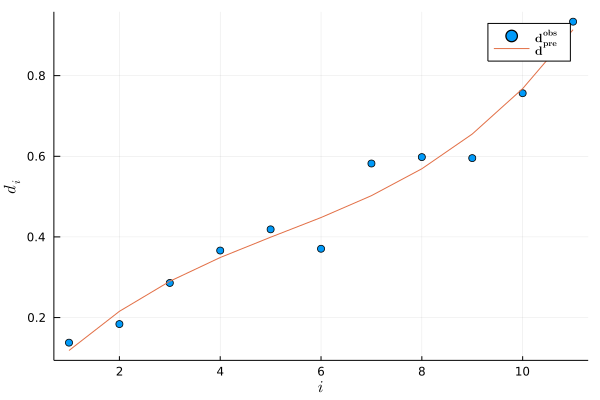

In [6]:
z = Vector(LinRange(0, 1, 11)) # (A) linear spacing, start=0, stop=10, # of values=11
# (B) assign true m by sampling uniform distribution
u = Uniform(-1, 1)
mTrue = rand(u, 4)
G = [ones(11) z z.^2 z.^3] # (C) Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.05) # (D) synthetic data
(mEst, stats) = cgls(G, dObs) # (E) least squares
dPre = G * mEst # (F) calculate predicted data

plot(dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"i", ylabel=L"d_i") # (G) plot
plot!(dPre, label=L"\mathbf{d^{pre}}")

The model matches well when the data approximately follows a trend, even if it is non-linear. However, on some interations that data is spaced wildly and the model is a terrible fit. I believe these instances are caused by high Gaussian noise in the fake data and would become less prominent with a larger number of datapoints. The plot below demonstates this by increasing data to 250 points.

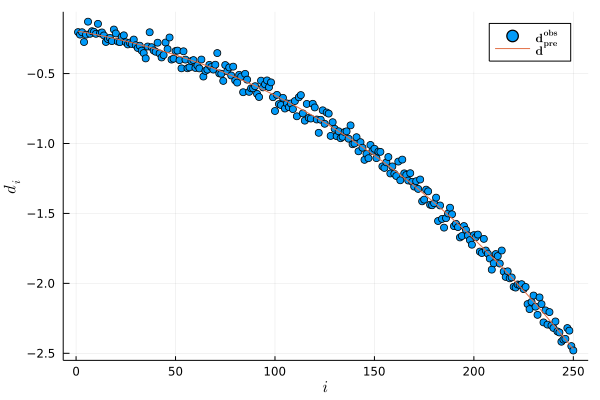

In [7]:
z = Vector(LinRange(0, 1, 250)) # (A) linear spacing, start=0, stop=10, # of values=11
# (B) assign true m by sampling uniform distribution
u = Uniform(-1, 1)
mTrue = rand(u, 4)
G = [ones(250) z z.^2 z.^3] # (C) Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.05) # (D) synthetic data
(mEst, stats) = cgls(G, dObs) # (E) least squares
dPre = G * mEst # (F) calculate predicted data

plot(dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"i", ylabel=L"d_i") # (G) plot
plot!(dPre, label=L"\mathbf{d^{pre}}")

# Q4 | Problem 3.5

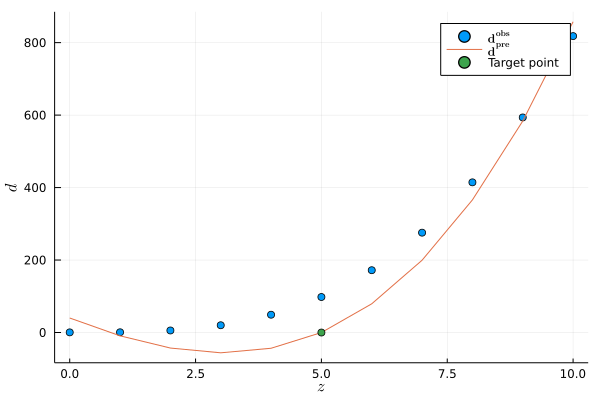

In [8]:
# The book asks for range 0 to 1 but if we then plot against z, fitting a point to z=5 is not very natural. I think 1 to 10, as in Problem 1.3 works better - feels like a book error to me.
z = Vector(LinRange(0, 10, 11)) # (A) linear spacing, start=0, stop=10, # of values=11
# (B) assign true m by sampling uniform distribution
u = Uniform(-1, 1)
mTrue = rand(u, 4)
G = [ones(11) z z.^2 z.^3] # (C) Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.05) # (D) synthetic data

function ConstrainedFit(G::Matrix, H::Matrix, h::Vector)::Vector
    lMatrix = [transpose(G)*G transpose(H); H 0]
    rMatrix = vcat(transpose(G)*dObs, h)
    inv(lMatrix)*rMatrix
end

zp = 5
dp = 0
H = [1 zp zp^2 zp^3]
h = [dp]

mEst = ConstrainedFit(G, H, h)

dPre = G * mEst[1:4] # (F) calculate predicted data

plot(z, dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"z", ylabel=L"d") # (G) plot
plot!(z, dPre, label=L"\mathbf{d^{pre}}")
plot!([zp], [dp], seriestype=:scatter, label="Target point")

While the model does always pass through the constraint, as desired, this doesn't do good things for the fit. The fact that the data doesn't fit this constraint suggests to me the constraint is flawed.

# Q5

The fourth parameter is 1.0.


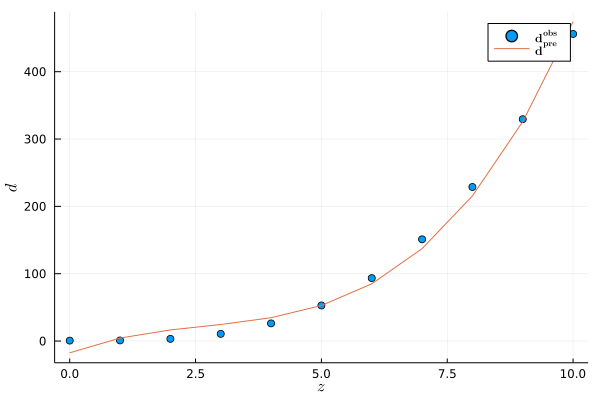

In [13]:
# The book asks for range 0 to 1 but if we then plot against z, fitting a point to z=5 is not very natural. I think 1 to 10, as in Problem 1.3 works better - feels like a book error to me.
z = Vector(LinRange(0, 10, 11)) # (A) linear spacing, start=0, stop=10, # of values=11
# (B) assign true m by sampling uniform distribution
u = Uniform(-1, 1)
mTrue = rand(u, 4)
G = [ones(11) z z.^2 z.^3] # (C) Kernel
dObs = FakeNormalData(G, mTrue, 0, 0.05) # (D) synthetic data

H = [0 0 0 1]
h = [1]

mEst = ConstrainedFit(G, H, h)

dPre = G * mEst[1:4] # (F) calculate predicted data

println("The fourth parameter is $(mEst[4]).")
plot(z, dObs, seriestype=:scatter, label=L"\mathbf{d^{obs}}", xlabel=L"z", ylabel=L"d") # (G) plot
plot!(z, dPre, label=L"\mathbf{d^{pre}}")

# Q6

Firstly, the dead end I went down:
- Trying to turn Hm into (1,1,1,1), perhaps by dividing m by its average. Can't get away with only using m once when you're doing that

The solution was rather different and appallingly simple, once it occured to me.
$$\mathbf{h} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}$$
$$\mathbf{H} = \begin{bmatrix} 1 & -1 & 0 & 0 \\ 1 & 0 & -1 & 0 \\ 1 & 0 & 0 & -1 \end{bmatrix}$$

# Q7

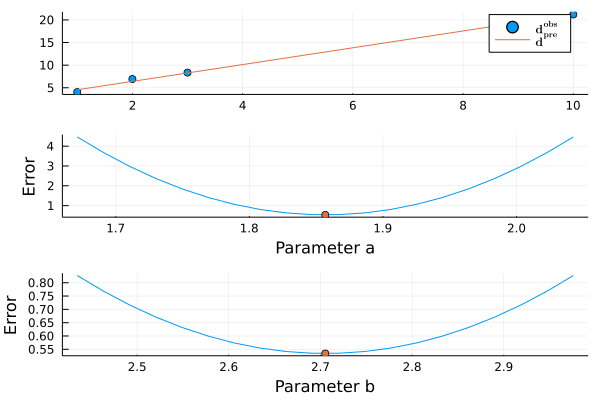

x: [1, 2, 3, 10]
y: [4.05, 6.93, 8.35, 21.2]
Parameters [a,b] are [1.8567999999999993, 2.705300000000002]
The associated covariance matrix for the model parameters is [0.019999999999999997 -0.07999999999999999; -0.07999999999999999 0.57]
The associated standard deviations are [0.1414213562373095, 0.7549834435270749]
N: [0.43 0.37 0.30999999999999994 -0.1099999999999999; 0.37 0.32999999999999996 0.29 0.010000000000000064; 0.31000000000000005 0.29 0.26999999999999996 0.13; -0.10999999999999988 0.010000000000000064 0.13 0.9699999999999999]
R: [0.9999999999999998 0.0; 8.881784197001252e-16 1.0]

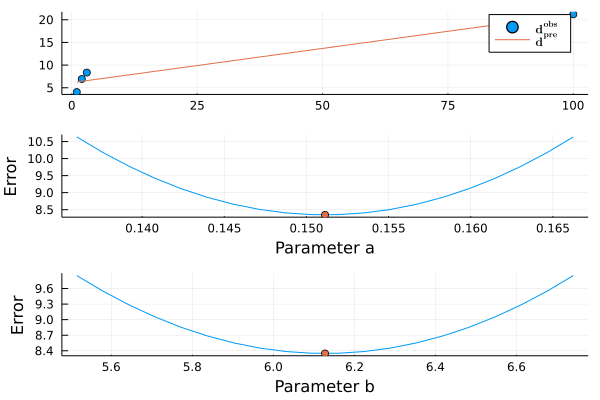


x: [1, 2, 3, 100]
y: [4.05, 6.93, 8.35, 21.2]
Parameters [a,b] are [0.1511332408049965, 6.127469118667591]
The associated covariance matrix for the model parameters is [0.00013879250520471893 -0.0036780013879250516; -0.0036780013879250516 0.34746703678001384]
The associated standard deviations are [0.01178102309668897, 0.5894633464262335]
N: [0.3402498265093684 0.33671061762664817 0.3331714087439278 -0.010131852879944492; 0.3367106176266481 0.3333102012491325 0.32990978487161693 6.939625260234811e-5; 0.33317140874392775 0.32990978487161693 0.326648160999306 0.010270645385149189; -0.010131852879944503 6.93962526023828e-5 0.010270645385149213 0.9997918112421929]
R: [0.9999999999999999 -1.734723475976807e-18; -8.881784197001252e-16 1.0]


In [218]:
"""
Finds generalised inverse of a kernel G for a least squares problems.
"""
function GeneralisedInverseLeastSq(G::Matrix)::Matrix
    Gt = transpose(G)
    inv(Gt*G)*Gt
end

function FindErrorLeastSq(dObs::Vector, dPre::Vector)::Float64
    e = dObs - dPre
    transpose(e) * e
end


"""
Perturbs a model by a factor of ±mangitude in all parameters.

Parameters
    G::Matrix - Kernel for model
    m::Vector - Parameters of the model
    dObs::Vector - Observed data, used for evaluating FindErrorLeastSq
    iterations::Int - Number of peturbed values analysed per parameter
    magnitude::Float64 - Percentage to perturb by (as a decimal). e.g. 0.1 will perturb by ±10%.

Returns a Vector of length(m) matrices.
Each matrix corresponds to one parameter from m. Order matches order of parameters in m.
Each matrix has 2 columns and a row count determined by iterations. 
The first column is the perturbed parameter values.
The second column is the associated error values.
"""
function PeturbParameters(G::Matrix, m::Vector, dObs::Vector, iterations::Int=20, magnitude::Float64=0.1)::Vector{Matrix}
    results = Vector{Matrix}(undef, length(m))
    mMatrix = hcat([m for i in 1:iterations]...)
    for r in 1:length(m)
        p = m[r]
        pMatrix = copy(mMatrix)
        pMatrix[r,:] = LinRange((1-magnitude)*p, (1+magnitude)*p, iterations)
        E = Vector{Float64}(undef, iterations)
        for c in 1:iterations
            E[c] = FindErrorLeastSq(dObs, G * pMatrix[:,c])
        end
        results[r] = [pMatrix[r,:] E]
    end
    return results
end

"""
This function just chuckls steps a through d into a single function so I can easily run it on multiple datasets.
Assumes y = ax + b such that x is an auxillary variable and m=[a;b] are is parameter vector.

Parameters
    x::Vector - Auxiliary variables
    y::Vector - Data points
"""
function AnalyseStraightLine(x::Vector, y::Vector)
    G = [x ones(length(x))]

    Gg = GeneralisedInverseLeastSq(G)
    m = Gg * y # We're working with a tiny matrix so I'll do the fitting the slow way
    dPre = G * m

    covar = Covariance(G, 1)
    mStd = diag(covar) .^ 0.5

    N = G * Gg # Data resolution matrix
    R = Gg * G # Model resolution matrix

    ptb = PeturbParameters(G, m, y)

    println("x: $x")
    println("y: $y")
    println("Parameters [a,b] are $m")
    println("The associated covariance matrix for the model parameters is $covar")
    println("The associated standard deviations are $mStd")
    println("N: $N")
    println("R: $R")

    p1 = plot(x, [y dPre], seriestype=[:scatter :line], label=[L"\mathbf{d^{obs}}" L"\mathbf{d^{pre}}"])

    pErrs = Vector{Any}()
    pKeys = ["a", "b"] # Part of a quick and dirty solution to display parameter name
    for q in 1:length(ptb)
        t = ptb[q]
        j = m[q]
        tempPlot = plot(t[:,1], t[:,2],
                        legend=false,
                        xlabel="Parameter $(pKeys[length(pErrs)+1])",
                        ylabel="Error")
        plot!([j], [FindErrorLeastSq(y, G * m)], seriestype=:scatter)
        push!(pErrs, tempPlot)
    end

    plot(p1, pErrs..., layout=(length(pErrs)+1,1))

end


y =  [4.05; 6.93; 8.35; 21.2]
x1 = [1;    2;    3;    10]
display(AnalyseStraightLine(x1, y))
x2 = [1, 2, 3, 100]
display(AnalyseStraightLine(x2, y))

